<center>
<img src="img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>
Авторы материала: Ольга Дайховская (@aiho), Юрий Кашницкий (@yorko). 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 2
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь").

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../data/samsung_train.txt")
y_train = np.loadtxt("../data/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../data/samsung_test.txt")
y_test = np.loadtxt("../data/samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [4]:
# Ваш код здесь
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X = np.concatenate((X_train, X_test))
y =  np.concatenate((y_train, y_test))
print(X.shape, y.shape)

(7352, 561) (7352,) (2947, 561) (2947,)
(10299, 561) (10299,)


Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#print(X)
#print(X_scaled)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
# Ваш код здесь
pca = PCA(0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)
print(len(X_pca))

[0.50738221 0.06239186 0.02692564 0.02452871 0.01888936 0.01631395
 0.01414533 0.01216211 0.00985248 0.00949228 0.00858304 0.0080998
 0.00765863 0.00676668 0.00630242 0.00615718 0.00595335 0.00577195
 0.00563431 0.0054083  0.00518828 0.00502742 0.00473229 0.00463818
 0.00446848 0.00439868 0.00416863 0.00400809 0.00389072 0.00381339
 0.0036687  0.00364357 0.00349225 0.00346736 0.00335539 0.00329411
 0.00323824 0.00300508 0.00294254 0.00290452 0.00275765 0.00269864
 0.00264196 0.0025803  0.00255031 0.00247776 0.00245537 0.0023829
 0.00235902 0.00232044 0.0022836  0.00219182 0.00212631 0.00209145
 0.0020348  0.00201167 0.00198111 0.00194391 0.00192509 0.00189539
 0.00186403 0.00182923 0.00180956 0.00176364 0.00174188]
10299


**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [9]:
# Ваш код здесь
print(len(pca.explained_variance_ratio_))

65


**Варианты:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [10]:
# Ваш код здесь
print(round(pca.explained_variance_ratio_[0]*100))

51


Визуализируйте данные в проекции на первые две главные компоненты.

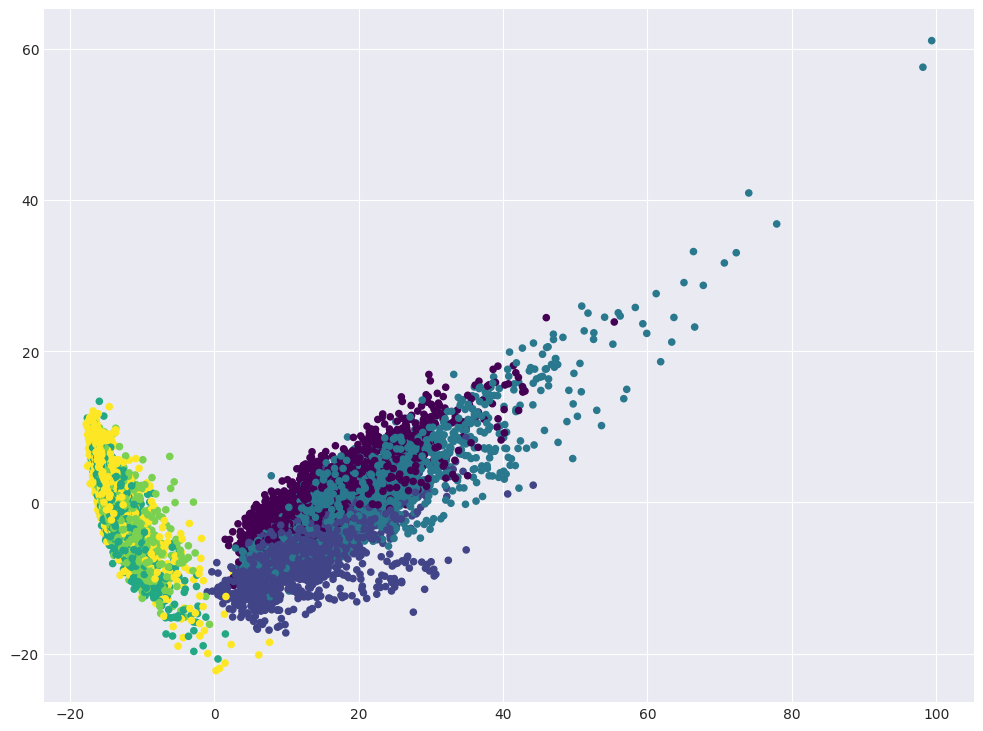

In [11]:
# Ваш код здесь
x = []
z = []
for i in range(len(X_pca)):
    x.append(X_pca[i][0])
    z.append(X_pca[i][1])
plt.scatter(x, z, c=y, s=20, cmap='viridis');

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
# Ваш код здесь
kmeans = KMeans(n_clusters=n_classes, n_init = 100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
print(kmeans)

KMeans(n_clusters=6, n_init=100, random_state=17)


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

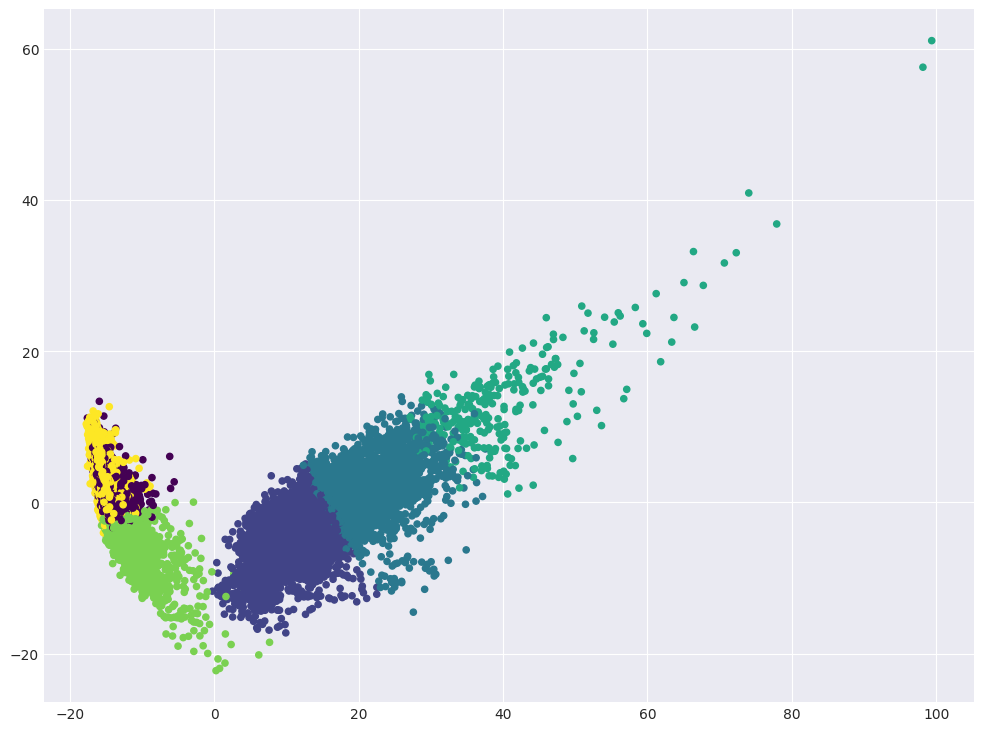

In [13]:
# Ваш код здесь
cluster_labels = kmeans.labels_
plt.scatter(x, z, c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [14]:
from pandas import crosstab

tab = crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

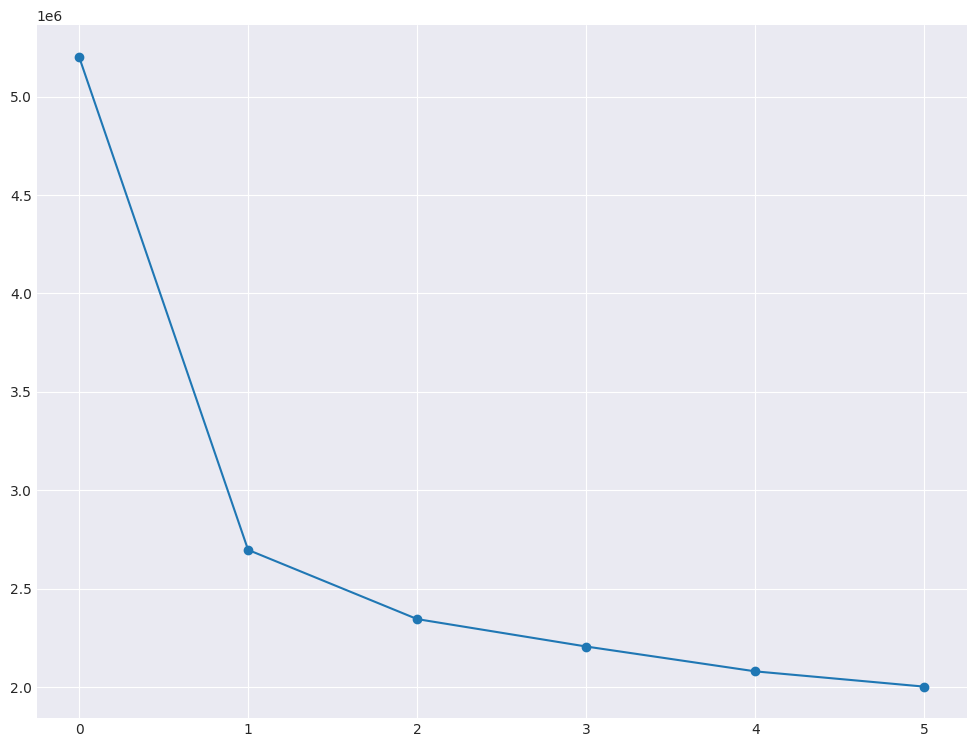

In [15]:
# Ваш код здесь
inertia = []
for k in range(1, n_classes + 1):
    kmeans = KMeans(n_clusters=k, n_init = 100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(kmeans.inertia_)


plt.plot(inertia, marker='o')
plt.show()

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

In [ ]:
%%sql


Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

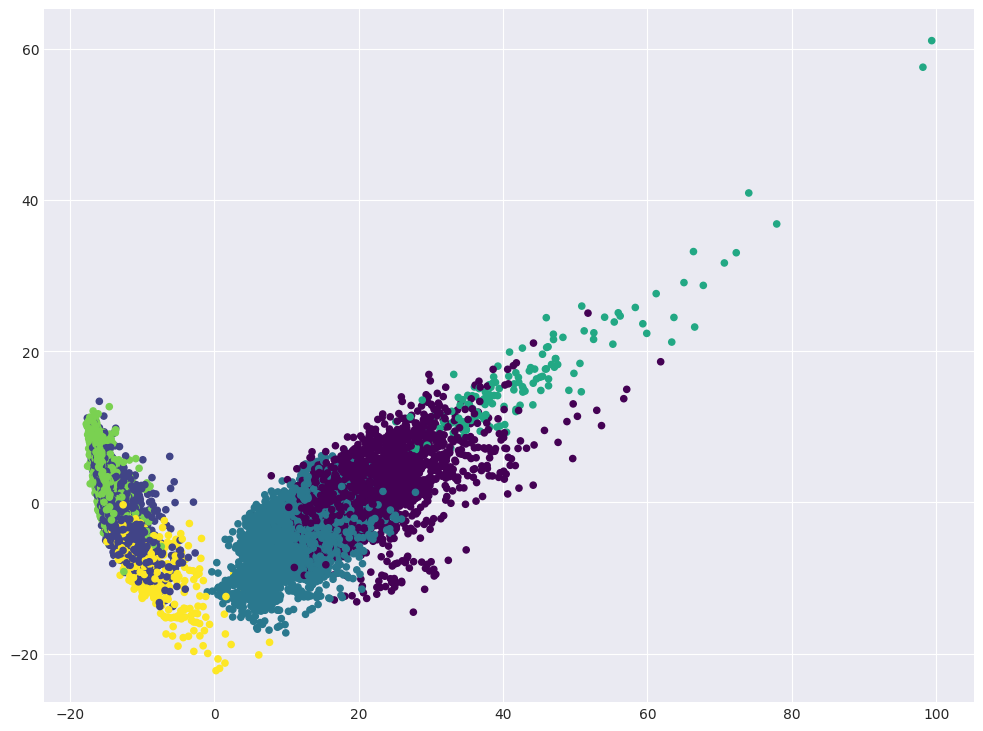

In [28]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)
plt.scatter(X_pca[:,0], X_pca[:,1], c=ag.labels_, s=20,  cmap='viridis');

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [31]:
from sklearn.metrics import rand_score
kmeans = KMeans(n_clusters=n_classes, n_init = 100, random_state=RANDOM_STATE).fit(X_pca)
ari1 = rand_score(y, kmeans.labels_)
ari2 = rand_score(y, ag.labels_)

print("KMeans:", ari1)
print("AgC:", ari2)
# Ваш код здесь


KMeans: 0.8248395125955338
AgC: 0.8345976189766343


**Вопрос 6:**<br>
Верно ли, что согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering?<br>

-------------------------------